# Object localization

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import matplotlib.patches as patches
from skimage.transform import SimilarityTransform, resize, warp, rotate, rescale
from skimage import data
from skimage import exposure
from skimage.transform import resize
import math
import time
import cv2
from sklearn import svm
from sklearn.model_selection import cross_val_score

Keras

In [29]:
from keras.utils.np_utils import to_categorical
from keras.utils import Sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, Callback
import keras.backend as K
import tensorflow as tf

## Pickle handler

In [3]:
class ModelSaver:
    def __init__(self, name = 'model', model = None):
        self.model = model
        self.fileName = name + '.pickle'
    def save(self, model = None):
        if (model == None):
            model = self.model
        pickle.dump(model, open(self.fileName, 'wb'))
    def load(self):
        model = pickle.load(open(self.fileName, 'rb'))
        return model

## Creating data

In [38]:
path = 'data/signs'

In [39]:
data = ModelSaver(path).load()

In [40]:
images, boundaries, signs = np.array(data['images']), np.array(data['boundaries']), data['signs']

In [41]:
def showImageWithSigns(image, sgns):   
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    for sign in sgns:
        x, y = sign['x'] - sign['w'] / 2, sign['y'] - sign['h'] / 2
        w, h = sign['w'], sign['h']
        rect = patches.Rectangle((x, y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

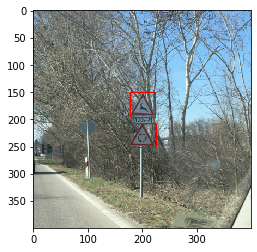

In [42]:
showImageWithSigns(images[12], signs[12])

In [82]:
maxWidthScale = 2

def getRandomImageOfSign(image, sign):
    prevx, prevy, w, h = int(sign['x']), int(sign['y']), int(sign['w']), int(sign['h'])
    maxW = min(w, h) * maxWidthScale
    newW = random.randint(max(w, h), maxW)
    minX, maxX, minY, maxY = prevx - (newW - w) / 2, prevx + (newW - w) / 2, prevy - (newW - h) / 2, prevy + (newW - h) / 2
    x, y = random.randint(int(minX), int(maxX)), random.randint(int(minY), int(maxY))
    x, y = max(x, 0), max(y, 0)
    x1, y1, x2, y2 = x - int(newW / 2), y - int(newW / 2), x + int(newW / 2), y + int(newW / 2)
    return image[y1:y2, x1:x2], w / newW, h / newW, (prevx - x1) / newW, (prevy - y1) / newW

def getRandomImageOfBlank(image, signs, boundaries):
    minW, maxW, = signs[0]['w'], signs[0]['w'] * maxWidthScale
    (x1, y1), (x2, y2) = boundaries
    minX, maxX, minY, maxY = 0, x1 * 0.8, 0, y1 * 0.8
    x1, y1 = random.randint(int(minX), int(maxX)), random.randint(int(minY), int(maxY))
    w = random.randint(int(minW), int(maxW))
    if random.random() < 0.5:
        x1 += int(x2)
    if random.random() < 0.5:
        y1 += int(y2)
    w = min(image.shape[0], y1 + w) - y1
    w = min(image.shape[1], x1 + w) - x1
    x2, y2 = x1 + w, y1 + w
    return image[y1:y2, x1:x2]

In [85]:
def showImageWithSign(output):   
    fig,ax = plt.subplots(1)
    ax.imshow(output[0])
    imW = output[0].shape[0]
    w, h = imW * output[1], imW * output[2]
    x, y = imW * output[3] - w / 2, imW * output[4] - h / 2
    rect = patches.Rectangle((x, y),w, h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

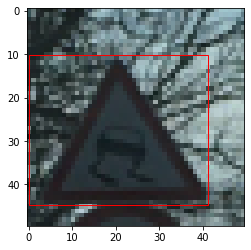

In [91]:
showImageWithSign(getRandomImageOfSign(images[0], signs[0][0]))

In [122]:
multplier = 100
def generateTrainingDataset(images, signs, boundaries):
    x = []
    y = []
    for i in range(0, len(images)):
        for _ in range(0, multplier):
            sign = random.randint(0, len(signs[i]) - 1)
            imageOfSign = getRandomImageOfSign(images[i], signs[i][sign])
            x.append(resize(imageOfSign[0], (32, 32)))
            y.append([1, imageOfSign[1], imageOfSign[2], imageOfSign[3], imageOfSign[4]])
            
            x.append(resize(getRandomImageOfBlank(images[i], signs[i], boundaries[i]), (32, 32)))
            y.append([0, 0, 0, 0, 0])
    
    return np.array(x, dtype='float32'), np.array(y, dtype='float32')

In [123]:
x, y = generateTrainingDataset(images, signs, boundaries)

In [124]:
def histogramEqualization(img):
    imgEq = exposure.equalize_hist(img)
    return imgEq

def meanNorm(imgs):
    print('Mean norm...')
    means = np.mean(imgs, axis=(1, 2, 3))
    normalized = np.array([img for img in imgs])
    for i in range(0, len(means)):
        normalized[i] -= means[i]
    return normalized

def stdNorm(imgs):
    print('Std norm...')
    stds = np.std(imgs, axis=(1, 2, 3))
    normalized = np.array([img for img in imgs])
    for i in range(0, len(stds)):
        normalized[i] /= stds[i]
    return normalized

def shuffle(x, y):
    permutation = np.random.permutation(x.shape[0])
    x = np.take(x, permutation, axis=0)
    y = np.take(y, permutation, axis=0)
    return x, y

def minMaxNorm(imgs):
    print('Min-Max norm...')
    low = np.min(imgs, axis=(1, 2, 3))
    high = np.max(imgs, axis=(1, 2, 3))
    normalized = np.array([img for img in imgs])
    for i in range(0, len(imgs)):
        normalized[i] = (normalized[i] - low[i]) / (high[i] - low[i])
    return normalized * 2 - 1

def applyNormalization(imgs):
    imgs = imgs.astype(np.float32)
    imgs = meanNorm(imgs)
    imgs = stdNorm(imgs)
    imgs = minMaxNorm(imgs)
    return imgs

def preprocess(x, y):
    print('Histogram equalization...')
    x = histogramEqualization(x)
    x = applyNormalization(x)
    y = [ i for i in y ]
    shuffle(x, y)
    print('Done')
    return np.array(x), np.array(y)

In [125]:
x, y = preprocess(x, y)

Histogram equalization...
Mean norm...
Std norm...
Min-Max norm...
Done


In [126]:
def splitData(x, y):
    size = len(x)
    mask = np.random.random_sample(size) > 0.2
    training = (x[mask], y[mask])
    testing = (x[~mask], y[~mask])
    return training, testing

In [127]:
train, test = splitData(x, y)

In [128]:
ModelSaver('data/object-localization-train-test').save({
    'train': train,
    'test': test
})

In [129]:
data = ModelSaver('data/object-localization-train-test').load()
train = data['train']
test = data['test']

# Training methods

### Random transformations

In [4]:
def transform(img, translation=(0, 0), rotation=0.0, scale=1.0, brightness=0):
    translation = (translation[0] + img.shape[0] / 2 * (1 - scale), translation[1] + img.shape[1] / 2 * (1 - scale))
    transform = SimilarityTransform(translation=translation, scale=scale)
    rotated = rotate(img, rotation, mode='reflect')
    return warp(rotated, transform, mode='reflect')
    
def applyRandomTransformation(img):
    dx = random.randint(-2, 2)
    dy = random.randint(-2, 2)
    dphi = random.uniform(-7, 7)
    dscale = random.uniform(0.9, 1.1)
    return transform(img, (dx, dy), dphi, dscale)

def transformImages(imgs):
    return np.array([applyRandomTransformation(img) for img in imgs]) 

In [19]:
def showImage(img):
    low, high = np.min(img), np.max(img)
    img = (img - low) / (high - low)
    plt.imshow(img.astype('float32'), cmap=plt.get_cmap('gray_r'))
    plt.show()

### Keras trainers

In [7]:
class Generator(Sequence):
    def __init__(self, x_set, y_set, batch_size=12):
        self.x, self.y = x_set, y_set
        self.orig_x, self.orig_y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(self.x.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        low, high = idx * self.batch_size, (idx + 1) * self.batch_size
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]
        return batch_x, batch_y
    
    def on_epoch_end(self):
        print('Transforming images')
        start = time.time()
        self.x = transformImages(self.orig_x)
        end = time.time()
        print(int(end - start), 's')

In [232]:
class CNN:
    def __init__(self):
        self.model = self.getModel()
        self.model.compile(optimizer='adam', loss=self.loss(), metrics=['accuracy'])
        
    def getModel(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=4, padding='same', activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(200, activation='relu'))
        model.add(Dense(5, activation='sigmoid'))
        return model
        
    def train(self, x, y, xValid, yValid, epochs = 5):
        start = time.time()
        self.history = self.model.fit(
            x, y, epochs = epochs,
            batch_size = 12,
            validation_data = (xValid, yValid),
            verbose=2)
        end = time.time()
        print('Training model took', int(end - start), 's')
        
    def evaluate(self, x, y):
        print('Loss:', self.model.evaluate(x, y, verbose=0)[0])
    
    def predict(self, x):
        pred = self.model.predict(np.array([x]))[0]
        if pred[0] > 0.8:
            fig,ax = plt.subplots(1)
            img = x
            low, high = np.min(img), np.max(img)
            img = (img - low) / (high - low)
            ax.imshow(img)
            imW = x.shape[0]
            w, h = imW * pred[1], imW * pred[2]
            x, y = imW * pred[3] - w / 2, imW * pred[4] - h / 2
            rect = patches.Rectangle((x, y),w, h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            plt.show()
            
        if pred[0] < 0.2:
            showImage(x)
            print('no sign')
        return pred
    
    def clone(self):
        cnn = CNN()
        cnn.model = self.model
        return cnn
    
    def save(self, path):
        self.model.save_weights(path)
        
    def load(self, path):
        self.model.load_weights(path)
        
    def loss(self):
        def loss_fn(true, pred): 
            mask = K.cast(K.less(true[..., 0], 0.5), 'float32')
            K.expand_dims(mask, -1)
            return K.sum(K.square(true[..., 0] - pred[..., 0])) * mask + K.sum(K.square(true - pred)) * (1 - mask)
        return loss_fn

In [218]:
model = CNN()

In [222]:
model.train(train[0], train[1], test[0][:600], test[1][:600], 20)

Train on 19973 samples, validate on 600 samples
Epoch 1/20
 - 44s - loss: 1.0981 - accuracy: 0.6314 - val_loss: 0.2414 - val_accuracy: 0.6167
Epoch 2/20
 - 41s - loss: 0.4620 - accuracy: 0.5466 - val_loss: 0.1584 - val_accuracy: 0.5450
Epoch 3/20
 - 48s - loss: 0.3312 - accuracy: 0.5331 - val_loss: 0.1723 - val_accuracy: 0.5033
Epoch 4/20
 - 46s - loss: 0.2793 - accuracy: 0.5187 - val_loss: 0.1615 - val_accuracy: 0.5000
Epoch 5/20
 - 48s - loss: 0.2322 - accuracy: 0.5141 - val_loss: 0.1113 - val_accuracy: 0.4917
Epoch 6/20
 - 46s - loss: 0.1984 - accuracy: 0.5118 - val_loss: 0.1275 - val_accuracy: 0.4917
Epoch 7/20
 - 55s - loss: 0.1588 - accuracy: 0.5077 - val_loss: 0.1428 - val_accuracy: 0.4917
Epoch 8/20
 - 45s - loss: 0.1413 - accuracy: 0.5062 - val_loss: 0.1831 - val_accuracy: 0.4900
Epoch 9/20
 - 52s - loss: 0.1395 - accuracy: 0.5064 - val_loss: 0.1662 - val_accuracy: 0.4933
Epoch 10/20
 - 60s - loss: 0.1155 - accuracy: 0.5044 - val_loss: 0.1892 - val_accuracy: 0.4900
Epoch 11/20

In [221]:
model = model.clone()

## Evaluate results

In [241]:
copy.evaluate(train[0], train[1])

Loss: 0.08308415986910979


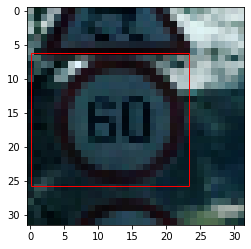

[0.9999201  0.72645706 0.61214453 0.3642788  0.49994922]


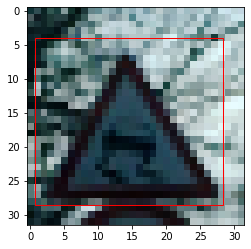

[0.9999858  0.8641244  0.7679597  0.45229742 0.5077438 ]


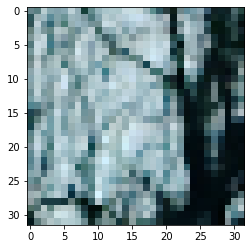

no sign
[1.4735181e-31 7.1304583e-13 1.8898817e-12 4.5129625e-12 3.1690095e-12]


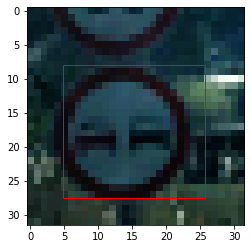

[0.9990662  0.6547043  0.6128017  0.47576833 0.55496836]


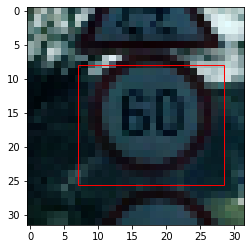

[0.9993456  0.6720024  0.54878783 0.554481   0.52502257]


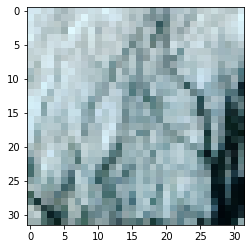

no sign
[2.7121184e-08 2.2568903e-04 2.8058578e-04 4.0042630e-04 3.2172966e-04]


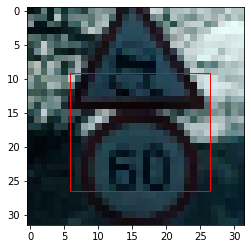

[0.99998605 0.64113784 0.53904104 0.503821   0.55716425]


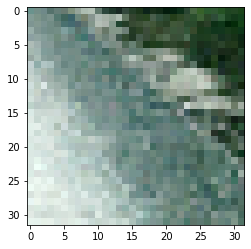

no sign
[2.9463163e-36 4.4047085e-14 7.5706517e-14 2.3071277e-13 3.0700069e-14]


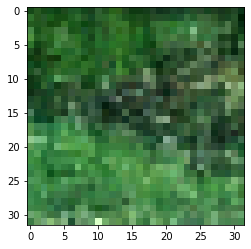

no sign
[2.3836212e-32 1.7853156e-12 2.0851365e-12 8.3463783e-12 1.1478968e-12]


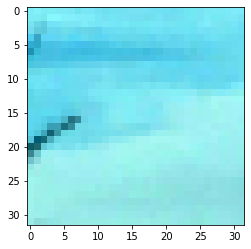

no sign
[3.2303178e-38 7.8772254e-16 1.1587907e-15 5.4858462e-15 1.8288079e-15]


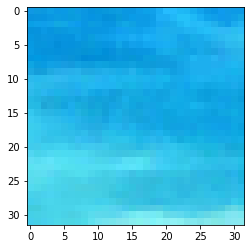

no sign
[0.0000000e+00 1.1142418e-21 1.4223616e-21 2.0061813e-20 2.2242848e-21]


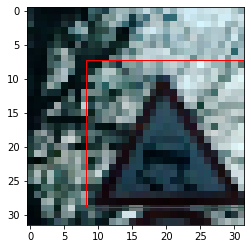

[0.999964  0.7603922 0.6747232 0.6359904 0.5646034]


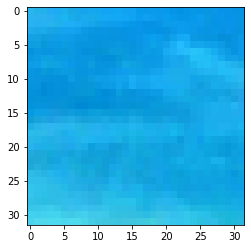

no sign
[0.0000000e+00 7.0195432e-26 8.8888477e-26 2.8043747e-24 1.5549377e-25]


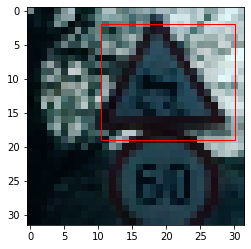

[0.9999362  0.61525387 0.53380567 0.6326833  0.32606962]


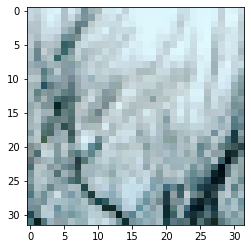

no sign
[4.5222071e-20 2.7009213e-08 3.3658029e-08 5.4935192e-08 2.7080707e-08]


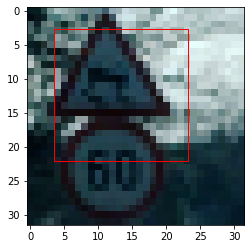

[0.99982196 0.61692244 0.6108301  0.41808012 0.3872196 ]


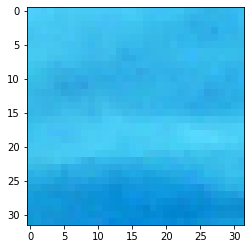

no sign
[0.0000000e+00 3.8742096e-26 7.3827317e-26 9.3645023e-24 2.2662909e-25]


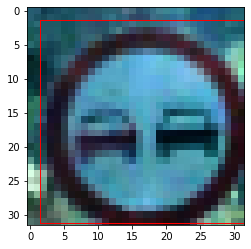

[0.9999999  0.94554293 0.9346421  0.51899886 0.5109343 ]


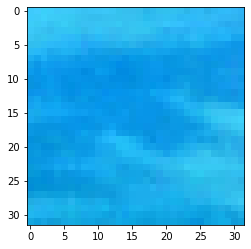

no sign
[0.0000000e+00 1.7118375e-22 2.0114055e-22 4.0419272e-21 3.6396154e-22]


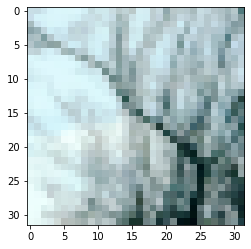

no sign
[5.8925004e-10 1.2324535e-04 1.6051077e-04 1.9519225e-04 1.8428064e-04]


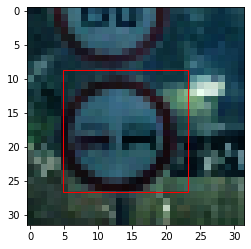

[0.9886342  0.5739535  0.56144845 0.43697885 0.5526061 ]


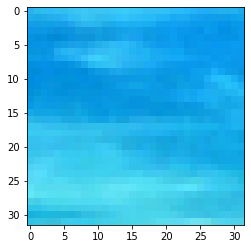

no sign
[0.00000000e+00 3.28774823e-26 5.51142663e-26 2.20364902e-24
 1.00905744e-25]


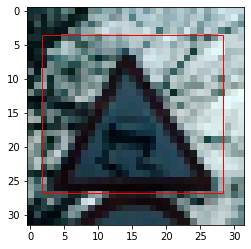

[0.9999833  0.8328411  0.72786486 0.46797785 0.47602198]


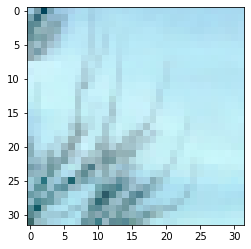

no sign
[4.0198569e-16 9.3605485e-07 1.2543605e-06 2.6610853e-06 1.2828351e-06]


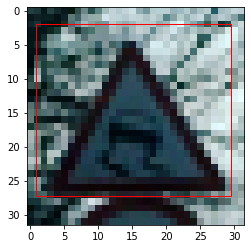

[0.9999945  0.8960686  0.79351044 0.47439966 0.45694137]


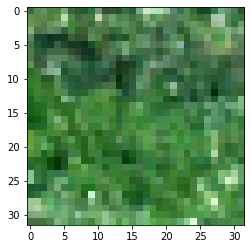

no sign
[3.1665844e-36 7.0064234e-14 7.0637201e-14 2.6211436e-13 2.0549226e-14]


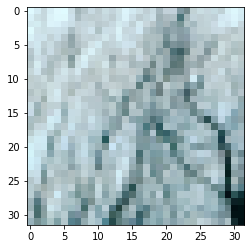

no sign
[2.6979306e-15 1.3258659e-06 1.8558188e-06 4.1377816e-06 2.1339915e-06]


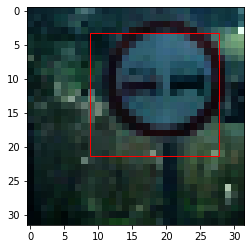

[0.99566877 0.59235644 0.566963   0.56953347 0.38424805]


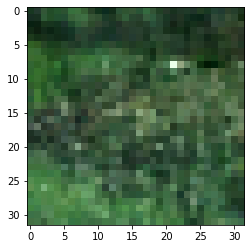

no sign
[1.7926979e-29 1.5930868e-11 1.7554633e-11 6.1204763e-11 5.7685241e-12]


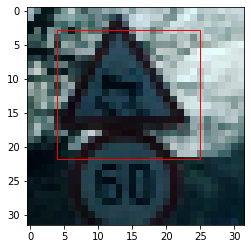

[0.99984133 0.6583499  0.5903449  0.45295545 0.38545516]


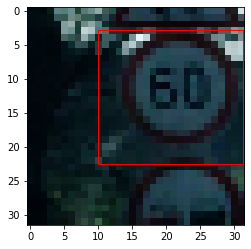

[0.9999925  0.67020357 0.6156596  0.6451654  0.39502853]


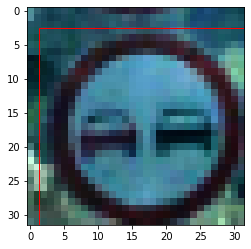

[1.         0.9500453  0.90634197 0.512988   0.530665  ]


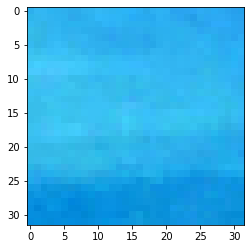

no sign
[0.0000000e+00 1.1483040e-31 2.6939904e-31 7.0038055e-29 7.9646090e-31]


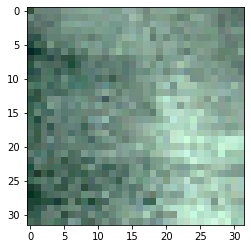

no sign
[0.0000000e+00 1.2180425e-18 1.5768896e-18 7.8419592e-18 3.8770175e-19]


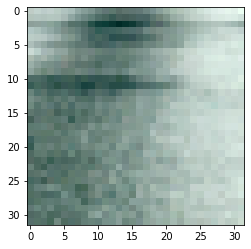

no sign
[0.00000000e+00 1.51974105e-17 2.46222353e-17 1.10959576e-16
 7.74749356e-18]


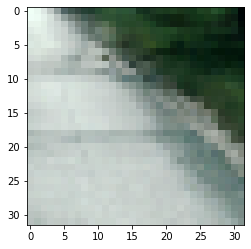

no sign
[9.8074353e-25 1.6675598e-09 1.9159261e-09 2.7388576e-09 6.9631539e-10]


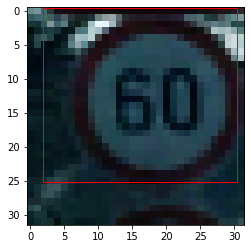

[0.999892   0.8897781  0.7982905  0.50399864 0.38720173]


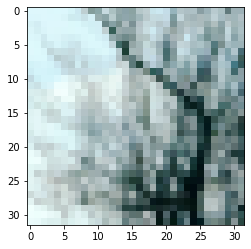

no sign
[1.08861503e-10 8.41384172e-05 1.09219502e-04 1.34827336e-04
 1.13980575e-04]


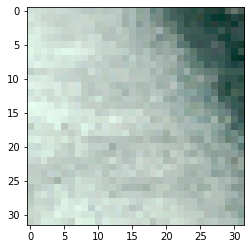

no sign
[8.6064146e-15 1.8510131e-05 1.4426986e-05 1.0950157e-05 6.5015201e-06]


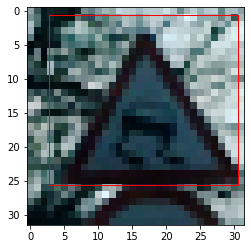

[0.99998903 0.86970586 0.7800585  0.5186821  0.4109507 ]


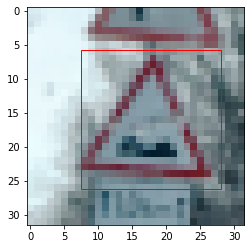

[0.99872017 0.64359665 0.6392785  0.55413926 0.49984652]


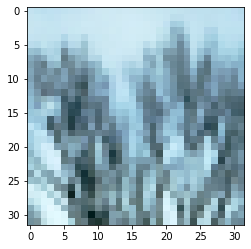

no sign
[0.0011182  0.02587431 0.02412994 0.01586662 0.02029374]


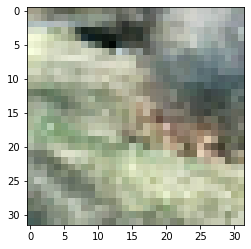

no sign
[0.0000000e+00 2.6475336e-16 4.8605768e-16 7.8789687e-16 1.6329534e-16]


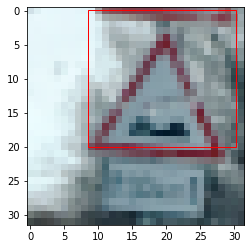

[0.9999945  0.67908585 0.6300572  0.60669893 0.30926028]


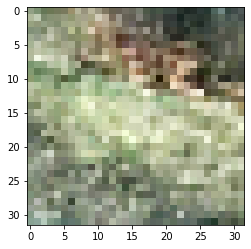

no sign
[1.6543234e-36 2.4171286e-14 2.3670249e-14 1.1965113e-13 7.6110857e-15]


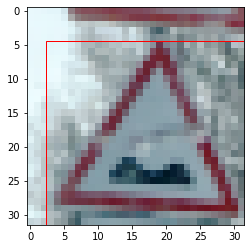

[0.99999416 0.90867305 0.8858413  0.52797425 0.5817588 ]


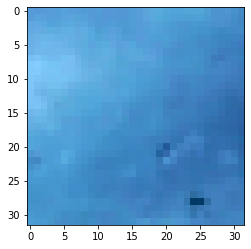

no sign
[0.00000000e+00 1.19243804e-20 2.21194897e-20 7.22919925e-19
 3.53608726e-20]


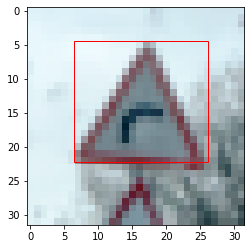

[0.99994326 0.6177968  0.5590338  0.5077087  0.41809568]


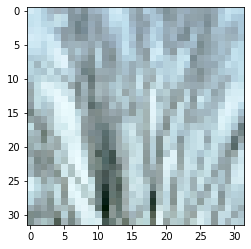

no sign
[1.0144814e-15 6.0637865e-07 7.9818085e-07 9.3882983e-07 5.9035585e-07]


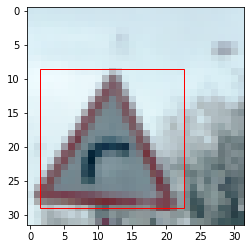

[0.9999751  0.66245633 0.6376547  0.37557256 0.5883574 ]


In [224]:
for i in range (0, 50):
    print(model.predict(test[0][i]))

In [235]:
model.save('models/object-localizer')

In [242]:
model = CNN()
model.load('models/object-localizer')